In [224]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Data
https://fred.stlouisfed.org/series/S4248SM144NCEN

In [225]:
df = pd.read_csv('../Data/Alcohol_Sales.csv',
                 index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [226]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


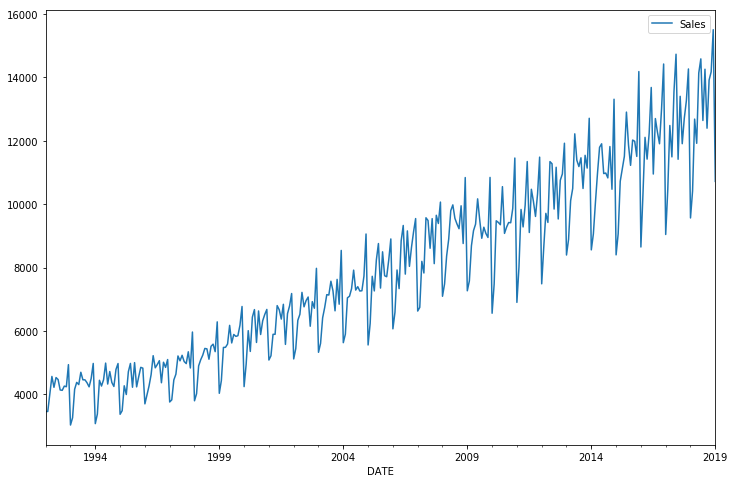

In [228]:
df.columns = ['Sales']

df.plot(figsize=(12,8));

**We can see some trend as well as some seasonality in the time series**

In [229]:
from statsmodels.tsa.seasonal import seasonal_decompose

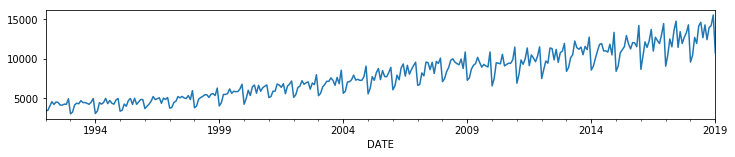

In [230]:
results = seasonal_decompose(df['Sales'])
# Total data
results.observed.plot(figsize=(12,2))

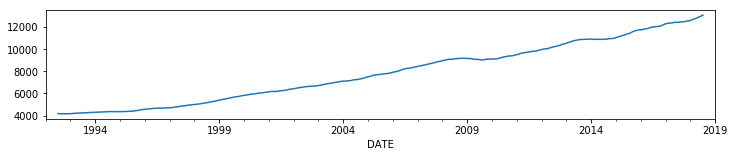

In [231]:
# Trend values: results.trend
results.trend.plot(figsize=(12,2)) # Trend

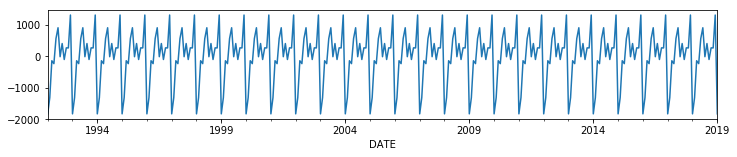

In [232]:
results.seasonal.plot(figsize=(12,2)) # Seasonal

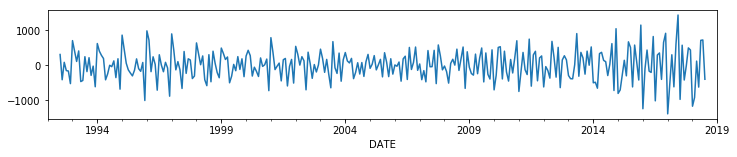

In [233]:
results.resid.plot(figsize=(12,2))

## Train Test Split

In [238]:
len(df)

325

In [239]:
325-12

313

In [240]:
train = df.iloc[:313]
test = df.iloc[313:]

In [241]:
len(test)

12

## Scale Data

In RNN, we look into weight and biases, if the values we have are too skewed, it is hard to determine weights and biases.

In [176]:
# (X - Xmin) / (Xmax - Xmin)
from sklearn.preprocessing import MinMaxScaler

In [242]:
scaler = MinMaxScaler()

In [243]:
# WE ONLY FIT TO TRAIN DATA, 
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [244]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [245]:
# We can do this directly
#scaled_train = scaler.fit_transform(train)
#scaled_test = scaler.transform(test)

# Time Series Generator

* RNN requires input as  [t1, t2, t3] and it would lead to [t4]. It will require a lot of effort to make batches of inputs. But Keras time series generator object does this automatically for us.

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [246]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [247]:
scaled_train[:5]

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ]])

In [248]:
scaled_test[:12]

array([[0.63116506],
       [0.82502778],
       [0.75972305],
       [0.94939738],
       [0.98743482],
       [0.82135225],
       [0.95956919],
       [0.80049577],
       [0.93025045],
       [0.95247457],
       [1.0661595 ],
       [0.65706471]])

We see in test set some values are above 1. This is because scale has been fit to training data. The highest value in training data will take the value of 1. So if values in test set is greater than highest value in training set, then after scaling it's value would be above 1. But till the values are in the similar scale it's ok to put them in the model.

#### Define generator that would take the time sequence such as training set and spit out the batches

In [249]:
# We can optimize n_input
n_input = 2

# Generally in time-series n_feature is 1 
# because 1 column is used in model, unless it's multivartiate RNN
n_features = 1

generator = TimeseriesGenerator(data=scaled_train, 
                                targets=scaled_train, 
                                length=n_input, batch_size=1)

Basically 2 inputs from training set is taken to predict the 3rd number in sequence. example-it will take 0.0365 and 0.0364 and predict 0.082 <br>

`batch_size` tells us how many batches we are planning to generate. Smaller batch size leads to better training. 1 batch_size works well. It has been seen higher batch_size might lead to overfitting to the training data.

In [250]:
len(scaled_train)

313

In [186]:
len(generator) # n_input = 2

311

`len(generator)` is exactly 2 less than `len(train)` because first 2 numbers are used as input

In [261]:
scaled_train[:5]

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ]])

In [252]:
# What does the first batch look like?
X,y = generator[0]

In [253]:
# INPUTS are first 2 datapoints of scaled train
X

array([[[0.03658432],
        [0.03649885]]])

In [254]:
# OUTPUT is the 3rd datapoint of scaled train
y

array([[0.08299855]])

In [255]:
print(f'Given the Array: {X.flatten()}\n')
print(f'Predict this y: {y}')

Given the Array: [0.03658432 0.03649885]

Predict this y: [[0.08299855]]


In [256]:
# Let's redefine to get 12 months back and 
# then predict the next month out
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, 
                                length=n_input, batch_size=1)

In [257]:
len(scaled_train), len(generator), (313-12)

(313, 301, 301)

In [258]:
# What does the first batch look like?
X,y = generator[0]

In [259]:
print(f'Given the Array: {X.flatten()}\n')
print(f'Predict this y: {y}')

Given the Array: [0.03658432 0.03649885 0.08299855 0.13103684 0.1017181  0.12804513
 0.12266006 0.09453799 0.09359774 0.10496624 0.10334217 0.16283443]

Predict this y: [[0.]]


So **Time Series Generator** can produce batches of input and label (input's next element) for training RNN. <BR>
    
Eventually, forcasted values can be also taken as input to predict further into future

### Create the Model

In [262]:
# Sequential allows a bunch of layers to add in sequence
from keras.models import Sequential

# Dense CONNECTS all neurons 4m previous layer to next layer
from keras.layers import Dense

# Long short term memory
from keras.layers import LSTM

In [263]:
(n_input, n_features)

(12, 1)

In [264]:
# define model
model = Sequential()
# 100 Neurons
model.add(LSTM(100, activation='relu', 
               input_shape=(n_input, n_features)))

# One final output of y, so only 1 neuron
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [265]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [266]:
# fit model
# 1 Epoch is an entire run through the training data
model.fit_generator(generator,epochs=50)

Epoch 1/50
301/301 [==============================] - 8s 27ms/step - loss: 0.0176
Epoch 2/50
301/301 [==============================] - 7s 25ms/step - loss: 0.0108
Epoch 3/50
301/301 [==============================] - 8s 26ms/step - loss: 0.0080
Epoch 4/50
301/301 [==============================] - 8s 26ms/step - loss: 0.0082
Epoch 5/50
301/301 [==============================] - 8s 27ms/step - loss: 0.0065
Epoch 6/50
301/301 [==============================] - 8s 27ms/step - loss: 0.0055
Epoch 7/50
301/301 [==============================] - 8s 28ms/step - loss: 0.0038
Epoch 8/50
301/301 [==============================] - 8s 28ms/step - loss: 0.0039
Epoch 9/50
301/301 [==============================] - 8s 28ms/step - loss: 0.0030
Epoch 10/50
301/301 [==============================] - 8s 28ms/step - loss: 0.0025
Epoch 11/50
301/301 [==============================] - 8s 28ms/step - loss: 0.0018
Epoch 12/50
301/301 [==============================] - 8s 28ms/step - loss: 0.0019
Epoch 13/50
3

In [267]:
# What keys are stored in the trained model summary dictionary
model.history.history.keys()

dict_keys(['loss'])

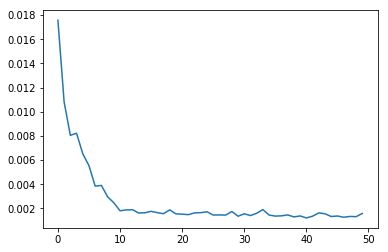

In [268]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluate on Test Data

**Here model will take 12 history steps and predict the next step. So we need last 12 points of the training data to predict the 1st point of test data.**

In [269]:
first_eval_batch = scaled_train[-12:]

In [270]:
first_eval_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [271]:
 n_input, n_features

(12, 1)

In [272]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [273]:
model.predict(first_eval_batch)

array([[0.69187784]], dtype=float32)

In [274]:
# Given last 12 points of training data model predicts 
# 13th point (1st point in test set) to be 0.63
scaled_test[0]

array([0.63116506])

Now let's put this logic in a for loop to predict into the future for the entire test range.

----

In [275]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [276]:
current_batch.shape

(1, 12, 1)

In [277]:
current_batch

array([[[0.63432772],
        [0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ]]])

In [278]:
# Removing first element and adding a element at the end
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[ 0.80776135],
        [ 0.72313873],
        [ 0.89870929],
        [ 1.        ],
        [ 0.71672793],
        [ 0.88648602],
        [ 0.75869732],
        [ 0.82742115],
        [ 0.87443371],
        [ 0.96025301],
        [ 0.5584238 ],
        [99.        ]]])

**NOTE: PAY CLOSE ATTENTION HERE TO WHAT IS BEING OUTPUTED AND IN WHAT DIMENSIONS. ADD YOUR OWN PRINT() STATEMENTS TO SEE WHAT IS TRULY GOING ON!!**

In [279]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))


# if we need to forecast for x number of months put `range(x)`
for i in range(len(test)):
    
    # get prediction 1 time stamp ahead 
    #([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],
                              axis=1)

In [280]:
test_predictions

[array([0.69187784], dtype=float32),
 array([0.7996697], dtype=float32),
 array([0.76330054], dtype=float32),
 array([0.9231388], dtype=float32),
 array([0.98195404], dtype=float32),
 array([0.74859864], dtype=float32),
 array([0.891669], dtype=float32),
 array([0.7683508], dtype=float32),
 array([0.8488292], dtype=float32),
 array([0.8867166], dtype=float32),
 array([0.9522783], dtype=float32),
 array([0.5885932], dtype=float32)]

In [281]:
scaled_test

array([[0.63116506],
       [0.82502778],
       [0.75972305],
       [0.94939738],
       [0.98743482],
       [0.82135225],
       [0.95956919],
       [0.80049577],
       [0.93025045],
       [0.95247457],
       [1.0661595 ],
       [0.65706471]])

## Inverse Transformations and Compare

In [282]:
true_predictions = scaler.inverse_transform(test_predictions)

In [283]:
true_predictions

array([[11125.27887297],
       [12386.33562118],
       [11960.8529948 ],
       [13830.80078942],
       [14518.88029224],
       [11788.85543317],
       [13462.63534266],
       [12019.93577534],
       [12961.4529255 ],
       [13404.69755292],
       [14171.70401913],
       [ 9916.95167071]])

In [284]:
test

,Sales
DATE,
2018-02-01,10415
2018-03-01,12683
2018-04-01,11919
2018-05-01,14138
2018-06-01,14583
2018-07-01,12640
2018-08-01,14257
2018-09-01,12396
2018-10-01,13914


In [285]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

/Users/sayantan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [286]:
test

,Sales,Predictions
DATE,,
2018-02-01,10415,11125.278873
2018-03-01,12683,12386.335621
2018-04-01,11919,11960.852995
2018-05-01,14138,13830.800789
2018-06-01,14583,14518.880292
2018-07-01,12640,11788.855433
2018-08-01,14257,13462.635343
2018-09-01,12396,12019.935775
2018-10-01,13914,12961.452926


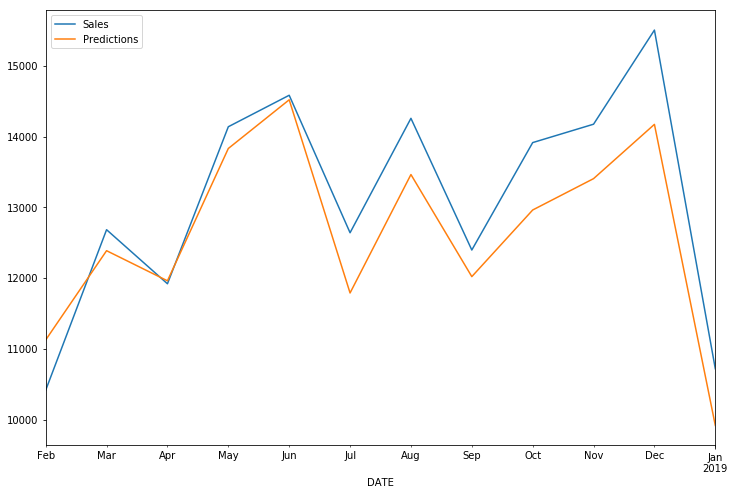

In [287]:
test.plot(figsize=(12,8))

In [291]:
# Model Evaluation could be performed here as well

# Saving and Loading Models

In [292]:
model.save('my_rnn_model.h5')

## load a model

In [293]:
from keras.models import load_model
new_model = load_model('my_rnn_model.h5')

In [294]:
new_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
